In [524]:
import numpy as np
import scipy.special as sc
from scipy.special import binom, factorial

# Coefficient Matrix

In [773]:
import math as m
from math import comb
from math import gamma as gam_f
from numpy import power as pow
np.set_printoptions(precision=5, linewidth=1000)


In [841]:
@np.vectorize
def lah(n,k):
    if n == 0 and k == 0:
        return 1
    if k<1 or n<1:
        return 0
    
    return (-1)**n*comb(n-1,k-1)*gam_f(n+1)/gam_f(k+1)


@np.vectorize 
def C_ij(n,i,j):
    if  i > n or j > n or j>i:
        return 0
    h = (i-j)
    return gam_f(h+j+1)*comb(n, h)*lah(n-h,j)
@np.vectorize
def K_ij(n, i,j, x,d):
    if d == 0:
        if i == n:
            return gam_f(n+1)
        else:
            return 0
    if  i > n or j > n:
        return 0
    beta = np.sqrt(d**2/(4*x+1+d**2))
    return C_ij(n,i,j)*(2/d)**(2*(n+(j-i)))* beta**(2*(n+ 2*j-i))

#runs in a millisecond


K_ij(1,I,J, 1 , 1) 

array([[ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 1.     , -0.11111,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ]])

In [604]:
n = 4
x = 0
d = np.sqrt(2)
beta = np.sqrt(d**2/(4*x+1+d**2))


I, J = np.mgrid[0:n+1, 0:n+1]


K = np.array(C_ij(n,I,J) , dtype=int)
print(K)
K = K*(2/d)**(2*(n+(J-I)))* beta**(2*(n+ 2*J-I))
print(K)

[[   0    0    0    0    0]
 [   0   24    0    0    0]
 [   0  -48   72    0    0]
 [   0   72 -144   72    0]
 [  24  -96  144  -96   24]]
[[   0.              0.              0.              0.              0.          ]
 [   0.             50.5679012346    0.              0.              0.          ]
 [   0.            -75.8518518519  101.1358024691    0.              0.          ]
 [   0.             85.3333333333 -151.7037037037   67.4238683128    0.          ]
 [  24.            -85.3333333333  113.7777777778  -67.4238683128   14.9830818473]]


# Integrals

This heavily relies on a mathematica workbook and some human calculations.

In [223]:
from scipy.special import hyp1f1, gamma, gammaincc

In [272]:

@np.vectorize 
def Integrals(a,b,x,alpha):
    initial = (1/(2 * (3 + 2 * b))) * np.exp(x * alpha) * np.pi * (alpha**(-1/2 + a - b))
    part1 = (3 + 2*b - 2*x * alpha) * hyp1f1(3 + a, 1/2 + a - b, -x * alpha) / gamma(1/2 + a - b) 
    part2 = x * alpha * hyp1f1(3 + a, 3/2 + a - b, -x * alpha) / gamma(3/2 + a - b)

    result = initial * (part1 + part2) * (-1)**(a-b) 

    if b == 0:
        other = 2
    else:
        other = 1/b

    return 2*np.pi*result * other

In [328]:
alpha = 0.5
print(I)
gam = np.sqrt(1/(1-beta**2))
print(Integrals(I,J,x,alpha))

[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]
[[ 1.575e+01  7.875e+00  1.181e+01  3.937e+01  2.067e+02]
 [-1.575e+01  7.875e+00  3.937e+00  7.875e+00  2.953e+01]
 [ 5.250e+00 -7.875e+00  3.937e+00  2.625e+00  5.906e+00]
 [-1.050e+00  2.625e+00 -3.937e+00  2.625e+00  1.969e+00]
 [ 1.500e-01 -5.250e-01  1.312e+00 -2.625e+00  1.969e+00]]


# Sums

In [756]:
def g(a, b, x ,dx,dy,dz, alpha, cutoff):
    
    '''
    Outputs derivative of the zeta correctly **ONLY** for d = [0,0,0] 
    where the expression is trivial to evaluate for all s derivatives.
    Crucially, this does not include the s! factor, for convenience
    when taylor expanding.
    d ≠ 0 can be evaluated but will be some approximation of the true result

    The inputs are x, the cutoff, the derivative order s and d
    '''

    d = np.array([dx,dy,dz])
    ML = 4
    m_tilde_sq = (ML/np.pi)**2
    
    d_scalar = np.linalg.norm(d)
    s = 4*x + m_tilde_sq
    E = np.sqrt(d_scalar**2 + 4*x + m_tilde_sq)
    if d_scalar:
        beta_norm = d/np.linalg.norm(d)
        beta = d_scalar/E
        gamma = 1/np.sqrt(1-beta**2)
    else:
        beta_norm = d
        beta = 0
        gamma = 1


    #create spherical shell containing the n vectors
    rng = np.arange(-int(np.sqrt(cutoff))-1, int(np.sqrt(cutoff))+2)
    res = (rng[:,np.newaxis, np.newaxis]**2+rng[np.newaxis,:,np.newaxis]**2+rng[np.newaxis,np.newaxis,:]**2)
    X,Y,Z = np.meshgrid(rng,rng,rng, indexing = 'ij')
    coords = np.stack((X,Y,Z), axis=3)
    r = coords[res<=cutoff]


    ####### Use Rummakainen and Gottlieb's formula
    r_2 = np.einsum("ij,ij->i", r,r)
    r_parallel  = np.einsum("ij,j->i", r, beta_norm)
    #use braodcasting to multiply each of the dot products by the beta unit vector
    r_perp_sq = r_2 -r_parallel**2
    rho = r_parallel+ 1/2 * d_scalar
    r_parallel_star = 1/gamma*(rho)
    r_parallel_star_sq = r_parallel_star**2
    r_sq = r_parallel_star_sq+ r_perp_sq
    D = r_sq-x


    terms_2 = np.exp(-alpha*D)/(D)**(a+1)*rho**(2*b)
    return np.sum(terms_2)#/np.sqrt(4*np.pi)

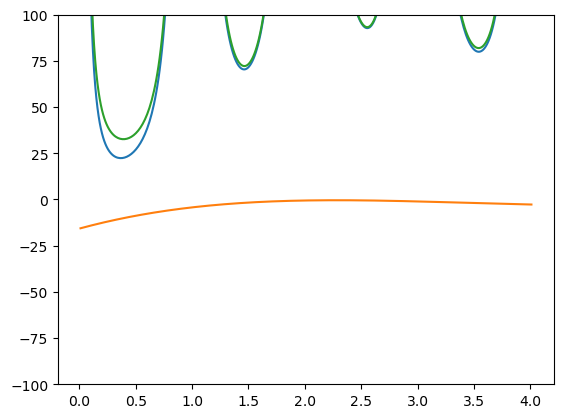

In [839]:
y1 = np.array([])
y2 = np.array([])
x = np.linspace(0.01,4.01,400)


for i in x:
    y1 = np.append(y1,g(1,0,i,0,0,0,0.5,1000))
    y2 = np.append(y2, Integrals(1,0,i,0.5))


import matplotlib.pyplot as plt

plt.plot(x,y1)
plt.plot(x,y2)

plt.plot(x,y1-y2)

plt.ylim(-100,100)
plt.show()



# Composite

Here we define a matrix that only has entries in the lower triangular part.

In [842]:
def deltaFV(a,b,x,dx,dy,dz,alpha, cutoff, gam):
    if(b>a):
        return 0
    elif (a==0 and b==0):
        return 0
    return (g(a,b,x,dx,dy,dz,alpha, cutoff)-gam**(2*b+1)*Integrals(a,b,x,alpha))

In [727]:
alpha = 0.1
gam = np.sqrt(1/(1-beta**2))
cutoff = 1000
d_vec = np.array([1,0,0])
dx, dy,dz = d_vec[0], d_vec[1], d_vec[2]
n_max = 4

FV_matrix = np.zeros((n_max+1,n_max+1))

for i in range(n_max+1):
    for j in range(n_max+1):
        FV_matrix[i,j] = deltaFV(i,j,x,dx,dy,dz,alpha, cutoff, gam)


print(FV_matrix)

ValueError: operands could not be broadcast together with shapes (800,) (132451,) 

In [365]:
alpha = 0.1
gam = np.sqrt(1/(1-beta**2))
cutoff = 100
d_vec = np.array([1,0,0])
dx, dy,dz = d_vec[0], d_vec[1], d_vec[2]
n_max = 4

FV_matrix = np.zeros((n_max+1,n_max+1))

for i in range(n_max+1):
    for j in range(n_max+1):
        FV_matrix[i,j] = deltaFV(i,j,x,dx,dy,dz,alpha, cutoff, gam)


print(FV_matrix)

[[     0.                0.                0.                0.                0.          ]
 [  -169.654323705    -175.9397733401      0.                0.                0.          ]
 [  -934.1844533398   -723.2529041809   -761.2243058343      0.                0.          ]
 [ -5976.3436160039  -4490.1884013655  -3437.4728657706  -3416.2353774502      0.          ]
 [-38601.4342977133 -28955.6858873342 -21749.7310733762 -16586.1161563244 -15796.9639524073]]


# Putting Everything together

We will use the functions from before to create the expressions for the nth derivative. First, we generate 

In [450]:
#here we define the user inputs

n_max = 5

d_vec = np.array([0,0,0])
x = 0.47
alpha = 0.1
cutoff = 100

d = np.linalg.norm(d_vec)
gam = np.sqrt(1/(1-beta**2))
dx, dy,dz = d_vec[0], d_vec[1], d_vec[2]

In [451]:
#We create the matrix of the FV terms

FV_matrix = np.zeros((n_max+1,n_max+1))
for i in range(n_max+1):
    for j in range(n_max+1):
        FV_matrix[i,j] = deltaFV(i,j,x,dx,dy,dz,alpha, cutoff, gam)

In [452]:
I, J = np.mgrid[0:n_max+1, 0:n_max+1]  

#time to evaluate the derivatives

derivatives = np.zeros((n_max))
for n in range(1,n_max+1):
    D_n = np.array(K_ij(n,I,J,x,d)) * FV_matrix
    derivatives[n-1] = np.nansum(D_n )


print(derivatives)


[-5.0760387352e+01 -1.0485001621e+02 -9.8412059330e+02 -3.7849651930e+03 -7.3664825682e+04]


# Create one function

In [720]:
def derivs(n_max, d_vec, x, alpha, cutoff):
    d = np.linalg.norm(d_vec)
    ML = 4
    m_tilde_sq = (ML/np.pi)**2
    beta = np.sqrt(d**2/(4*x+m_tilde_sq+d**2))
    gam = np.sqrt(1/(1-beta**2))
    dx, dy,dz = d_vec[0], d_vec[1], d_vec[2]

    FV_matrix = np.zeros((n_max+1,n_max+1))
    for i in range(n_max+1):
        for j in range(n_max+1):
            FV_matrix[i,j] = deltaFV(i,j,x,dx,dy,dz,alpha, cutoff, gam)

    I, J = np.mgrid[0:n_max+1, 0:n_max+1]  

    #print(FV_matrix)

    derivatives = np.array([])
    for n in range(1,n_max+1):
        K = np.array(K_ij(n,I,J,x,d))
        D_n = K* FV_matrix
        derivatives = np.append(derivatives,np.sum(D_n ))

    return derivatives

# Plotting

In [696]:
n_max = 15

d = np.array([1,0,0])
alpha = 0.1
cutoff = 100


x = np.linspace(0.1,10.1,300)
y = np.zeros((300, n_max))
for i in range(300):
    y[i] = derivs(n_max, d, x[i], alpha, cutoff)


[[ 0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00]
 [-5.5924434782e+02 -2.1321383587e+02  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00]
 [-7.9955178330e+03 -2.9976809496e+03 -1.1465697845e+03  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00]
 [-1.1875822105e+05 -4.4381572626e+04 -1.6597830499e+04 -6.2593284777e+03  0.0000000000e+00  0.0000000000e+00  0.0000000000e+00

KeyboardInterrupt: 

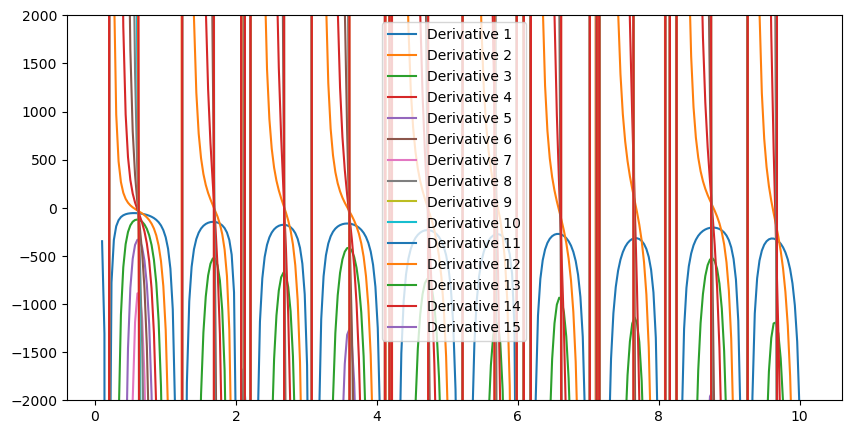

In [528]:
#plot derivs(n_max, d_vec, x, alpha, cutoff) for varyin x (0,10), 300 steps




import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
for i in range(n_max):
    plt.plot(x,y[:,i]/factorial(i+1), label = f"Derivative {i+1}")



plt.legend()
plt.ylim(-2000,2000)



plt.show()




# Comparison to numerical derivatives

Now we will compare it to the numerical derivatives from the other workbook

In [893]:
d = np.array([2,1,0])

In [894]:
##import data from file if exists

folder_name = "d_" + str(d).replace(" ", "").replace("[", "").replace("]", "")
path = "roots_zeta/" + folder_name + "/data.npz"
data = np.load(path)

q_2 = data['q_2']
z_d_results = data['z_d_results']
roots = data['zeros']
asymototes = data['asymptotes']
q_2_plot = np.copy(q_2)
zeta_plot = np.copy(z_d_results)

nth_root = 0
x_0  = roots[nth_root]


In [895]:
z_d_plot = np.copy(z_d_results)
q_2_plot = np.copy(q_2)

In [909]:
n_max = 2

#d = np.array([1,0,0])
alpha = 0.1
cutoff = 100


x = np.linspace(0.001,4.001,800)
y = np.zeros((len(x), n_max))
for i in range(len(x)):
    y[i] = derivs(n_max, d, x[i], alpha, cutoff)


In [910]:
print(y[:,0])

[1.25004e+02 1.25910e+02 1.27021e+02 1.28353e+02 1.29920e+02 1.31741e+02 1.33838e+02 1.36234e+02 1.38958e+02 1.42044e+02 1.45529e+02 1.49458e+02 1.53883e+02 1.58864e+02 1.64475e+02 1.70800e+02 1.77942e+02 1.86021e+02 1.95184e+02 2.05609e+02 2.17513e+02 2.31165e+02 2.46898e+02 2.65129e+02 2.86390e+02 3.11364e+02 3.40938e+02 3.76284e+02 4.18979e+02 4.71175e+02 5.35882e+02 6.17405e+02 7.22082e+02 8.59547e+02 1.04503e+03 1.30375e+03 1.67999e+03 2.25732e+03 3.20941e+03 4.94759e+03 8.65275e+03 1.89726e+04 7.09653e+04 1.73182e+07 9.34053e+04 2.17914e+04 9.50476e+03 5.31869e+03 3.40827e+03 2.37969e+03 1.76339e+03 1.36539e+03 1.09370e+03 9.00186e+02 7.57629e+02 6.49726e+02 5.66224e+02 5.00410e+02 4.47747e+02 4.05075e+02 3.70142e+02 3.41312e+02 3.17370e+02 2.97404e+02 2.80717e+02 2.66774e+02 2.55159e+02 2.45546e+02 2.37681e+02 2.31365e+02 2.26444e+02 2.22800e+02 2.20347e+02 2.19023e+02 2.18793e+02 2.19642e+02 2.21576e+02 2.24622e+02 2.28831e+02 2.34276e+02 2.41057e+02 2.49306e+02 2.59190e+02
 2.

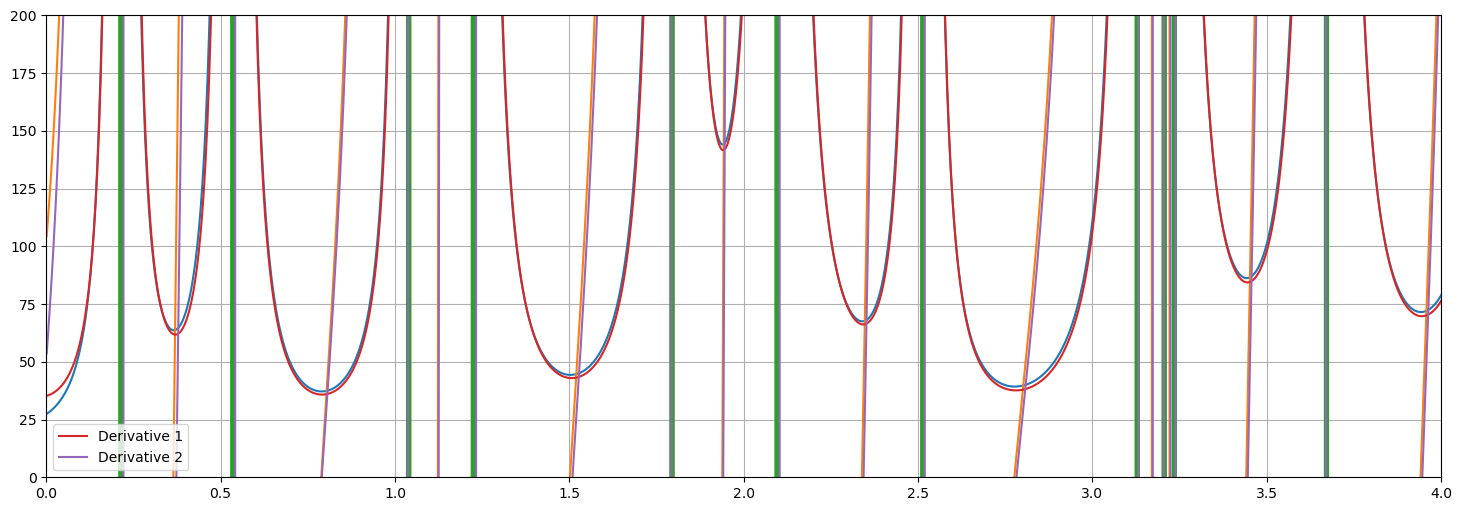

In [913]:
dx = np.diff(q_2_plot)[0]

dy_dx = np.diff(zeta_plot)/dx
d2y_dx2 = np.diff(dy_dx)/dx
d3y_dx3 = np.diff(d2y_dx2)/dx

plt.figure(figsize=(18,6))
plt.plot(q_2_plot[:-1], dy_dx)
plt.plot(q_2_plot[:-2], d2y_dx2)
plt.plot(q_2_plot[:-3], d3y_dx3)

for i in range(n_max):
    plt.plot(x,y[:,i]/np.sqrt(4*np.pi), label = f"Derivative {i+1}")

plt.legend()

plt.ylim(0,200)
plt.xlim(0,max(x))
plt.grid()

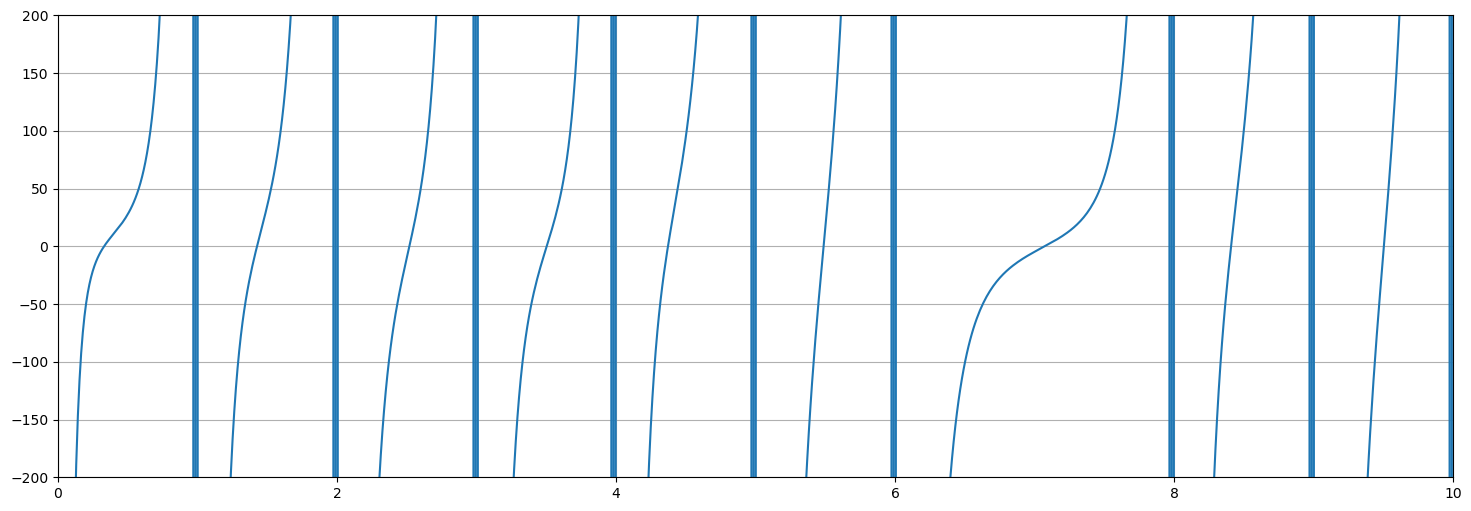

In [778]:
# plot second numerical derivaive
dx = np.diff(q_2_plot)[0]

dy_dx = np.diff(zeta_plot)/dx
d2y_dx2 = np.diff(dy_dx)/dx

plt.figure(figsize=(18,6))
plt.plot(q_2_plot[:-2], d2y_dx2)

plt.ylim(-200,200)
plt.xlim(0,10)
plt.grid()

